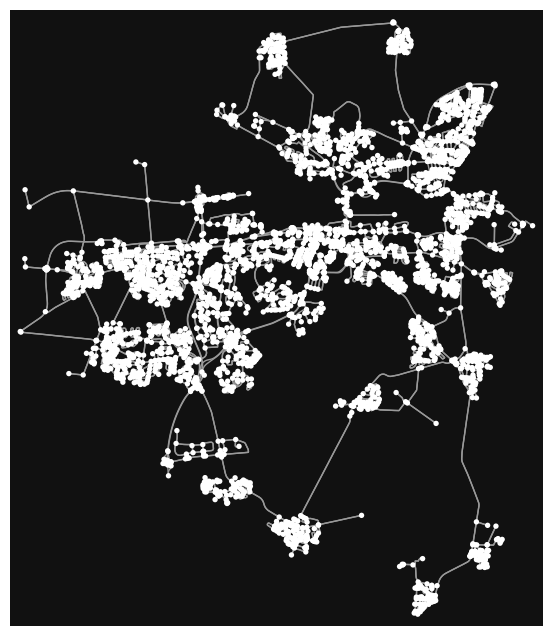

In [2]:
import osmnx as ox
import pandas as pd

place = "Wolfsburg, Germany"    # e.g. "Berlin, Germany"
highway_types = None       # None => include all. Or use list: ['motorway','primary','secondary','tertiary','residential','unclassified','living_street','service']


G = ox.graph.graph_from_place(place, network_type="drive")
fig, ax = ox.plot.plot_graph(G)


In [3]:
# what sized area does our network cover in square meters?
G_proj = ox.projection.project_graph(G)
nodes_proj = ox.convert.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.union_all().convex_hull.area
graph_area_m
# show some basic stats about the network
ox.stats.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 3893,
 'm': 9014,
 'k_avg': 4.6308759311584895,
 'edge_length_total': 1169514.4773009485,
 'edge_length_avg': 129.7442286777178,
 'streets_per_node_avg': 2.6416645260724376,
 'streets_per_node_counts': {0: 0,
  1: 872,
  2: 47,
  3: 2604,
  4: 347,
  5: 20,
  6: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.2239917801181608,
  2: 0.012072951451322887,
  3: 0.6688928846647829,
  4: 0.0891343436938094,
  5: 0.005137426149499101,
  6: 0.0007706139224248652},
 'intersection_count': 3021,
 'street_length_total': 652978.1976347632,
 'street_segment_count': 5144,
 'street_length_avg': 126.93977403475179,
 'circuity_avg': 1.1003242856406905,
 'self_loop_proportion': 0.008942457231726283,
 'clean_intersection_count': 2360,
 'node_density_km': 21.756840142306455,
 'intersection_density_km': 16.883486789084973,
 'edge_density_km': 6536.074884857391,
 'street_density_km': 3649.304459889785,
 'clean_intersection_density_km': 13.189350818351716}

In [4]:
edges = ox.graph_to_gdfs(G, nodes=False, edges =  True, fill_edge_geometry=True).to_crs(crs = 23030)
edges.head()

osmid  \
u      v          key                                                
514510 343496417  0    [315282904, 14383675, 723546027, 343309638]   
       514659     0                                      167393589   
       2872144234 0    [347238904, 340206083, 723546021, 52038270]   
       59656617   0                         [340206082, 340206084]   
514659 1411680005 0                                      127580574   

                           highway   lanes  maxspeed            name    ref  \
u      v          key                                                         
514510 343496417  0       tertiary       3  [50, 70]  Sandkrugstraße    K 2   
       514659     0       tertiary       2        50  Sandkrugstraße    K 2   
       2872144234 0      secondary  [3, 2]  [50, 70]      Zollstraße  L 290   
       59656617   0      secondary  [3, 2]        50      Zollstraße  L 290   
514659 1411680005 0    residential     NaN       NaN  Sandkrugstraße    NaN   

                       oneway reversed      length  \
u      v          key                                
514510 343496417  0     False    False  431.051094   
       514659     0     False     True  205.857570   
       2872144234 0     False     True  318.272993   
       59656617   0     False    False  332.901665   
514659 1411680005 0     False     True  235.785022   

                                                                geometry  \
u      v          key                                                      
514510 343496417  0    LINESTRING (1439464.976 5898576.388, 1439483.4...   
       514659     0    LINESTRING (1439464.976 5898576.388, 1439448.9...   
       2872144234 0    LINESTRING (1439464.976 5898576.388, 1439466.8...   
       59656617   0    LINESTRING (1439464.976 5898576.388, 1439463.8...   
514659 1411680005 0    LINESTRING (1439256.748 5898589.028, 1439256.6...   

                      junction bridge width tunnel access  
u      v          key                                      
514510 343496417  0        NaN    NaN   NaN    NaN    NaN  
       514659     0        NaN    NaN   NaN    NaN    NaN  
       2872144234 0        NaN    NaN   NaN    NaN    NaN  
       59656617   0        NaN    NaN   NaN    NaN    NaN  
514659 1411680005 0        NaN    NaN   NaN    NaN    NaN

## Street Names

In [5]:
edges['street_name'] = edges['name']
edges['street_name'] = edges['street_name'].apply(
    lambda x: '; '.join(x) if isinstance(x, list) else x
)

# Drop NaNs, get unique names, sort, reset index
street_names = (
    pd.Series(edges['street_name'].dropna().unique())
    .sort_values()
    .reset_index(drop=True)
)

street_df = pd.DataFrame({'street_name': street_names})
street_df

,street_name
0,Aachener Straße
1,Achtenbüttelweg
2,Ackerstücken
3,Adlerring
4,Adlerstraße
...,...
1323,Zur Wipperaller
1324,Zwergenweg
1325,Zwickauer Straße
1326,Örtzestraße


## Coordinates of streets

In [6]:
import pandas as pd
import json
from shapely.geometry import LineString, MultiLineString

def geom_to_coords_list(geom):
    """Return a flat list of (lon, lat) coordinate tuples for LineString or MultiLineString."""
    if geom is None:
        return []
    if isinstance(geom, LineString):
        return list(geom.coords)
    if isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    # other geometry types (Point) -> empty
    return []

edges_ll = edges.to_crs(epsg=4326)

# apply and build dataframe
df = edges_ll.reset_index().copy()  # keep u, v, key columns
df['coords_list'] = df['geometry'].apply(geom_to_coords_list)

# drop empty geometries if you want
# df = df[df['coords_list'].map(len) > 0]

df['coords_wkt']  = df['geometry'].apply(lambda g: g.wkt if g is not None else None)

# keep useful columns (name might be 'name' or 'street_name'; adjust as needed)
out = df[['name', 'coords_wkt']].rename(columns={'name':'street_name'})

out.head()

,street_name,coords_wkt
0,Sandkrugstraße,LINESTRING (10.84809730635252 52.4188123039757...
1,Sandkrugstraße,LINESTRING (10.84809730635252 52.4188123039757...
2,Zollstraße,LINESTRING (10.84809730635252 52.4188123039757...
3,Zollstraße,LINESTRING (10.84809730635252 52.4188123039757...
4,Sandkrugstraße,LINESTRING (10.845159806353337 52.419277703976...


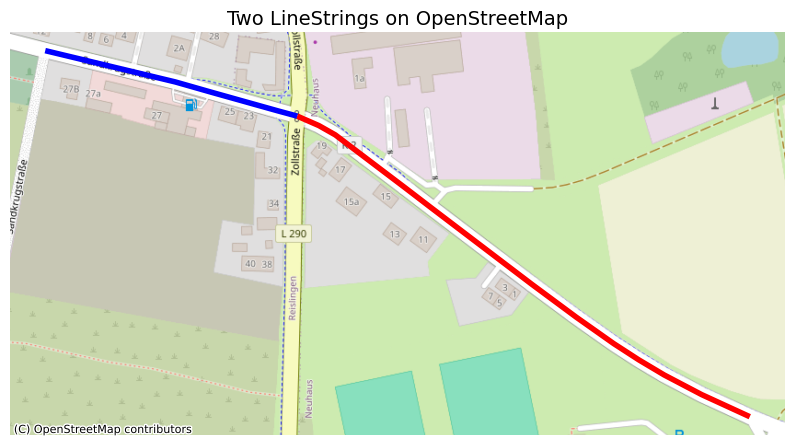

In [7]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.wkt import loads
import contextily as ctx

ls0 = out.iloc[0]['coords_wkt']
ls1 = out.iloc[1]['coords_wkt']
ls0 = loads(ls0)
ls1 = loads(ls1)
combined = gpd.GeoSeries([ls0, ls1], crs="EPSG:4326")
gs_web = combined.to_crs(epsg=3857)

# Plot with OSM basemap
fig, ax = plt.subplots(figsize=(10, 10))
gs_web.plot(ax=ax, color=['red', 'blue'], linewidth=4)

# Add OpenStreetMap tiles as basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Clean up plot
ax.set_axis_off()
ax.set_title("Two LineStrings on OpenStreetMap", fontsize=14)
plt.show()

In [8]:
street_names = df['street_name'].unique()
street_names

array(['Sandkrugstraße', 'Zollstraße', 'Käthe-Paulus-Straße', ...,
       'Am Welkensiek', 'Kaufhof', 'Hirschberger Straße'],
      shape=(1329,), dtype=object)

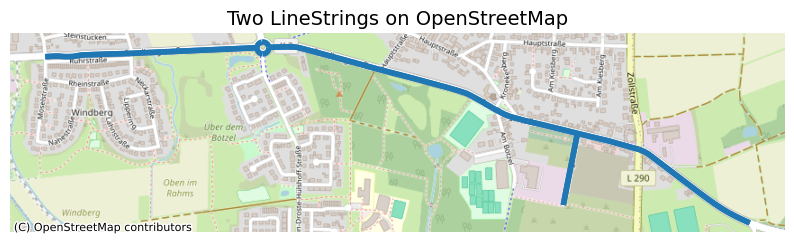

In [24]:
sample = df[df['street_name'] == 'Sandkrugstraße']
street_segments = []
for row in sample.itertuples():
    street_segments.append(loads(row.coords_wkt))
    
street_complete = gpd.GeoSeries(street_segments, crs="EPSG:4326")
gs_web = street_complete.to_crs(epsg=3857)

# Plot with OSM basemap
fig, ax = plt.subplots(figsize=(10, 10))
gs_web.plot(ax=ax,  linewidth=4)

# Add OpenStreetMap tiles as basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Clean up plot
ax.set_axis_off()
ax.set_title("Two LineStrings on OpenStreetMap", fontsize=14)
plt.show()


In [38]:
pivot = (
    edges.groupby('street_name')
    .size()                      # count rows per street name
    .reset_index(name='count')   # turn into a DataFrame
    .sort_values('count', ascending=False)
)
pivot[pivot['count'] > 10]

,street_name,count
246,Bruchgartenweg,76
1196,Von-Droste-Hülshoff-Straße,64
524,Helmstedter Straße,62
457,Große Riehe,52
519,Heinrich-Nordhoff-Straße,50
...,...,...
18,Alte Dorfstraße,12
782,Lönsstraße,12
1100,Spitzwegstraße,12
1208,Vorsfelder Straße,12


<Axes: >

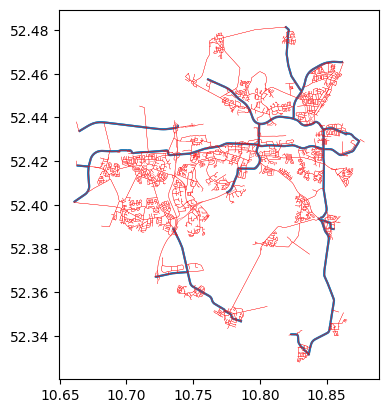

In [12]:
ax = edges_ll[edges.highway.isin(['primary', 'secondary'])].plot()
edges_ll.plot(ax = ax, lw = 0.2, color = 'red')